# A coastal flooding study: prediction & sensitivity analysis

Metamodeling course.
O. Roustant, October 2024.

Data kindly provided by the BRGM

*Rohmer, J., Idier, D., Paris, F., Pedreros, R., Louisor, J. (2018). Casting light on forcing and breaching scenarios that lead to marine inundation: Combining numerical simulations with a random forest classification approach. Environmental Modelling & Software, 104, p. 64-80*

We consider the problem of prediction the water height at the site "les Boucholeurs", in the west French coast, given 5 input variables representing weather and earth conditions. 

The dataset is composed of 500 flooding maps composed of 194 x 202 pixels, obtained with a design of experiment (DoE) of the 5 input variables. At each pixel, we measure the water height. In addition, for each map, we know the total flooded area. Such maps have been obtained with a time-consuming simulator (1 run $\approx$ 30 minutes to 1 hour). The aim is twofold: 1) to predict a water map for a new configuration in real-time, thus without running the simulator. 2) to quantify the influence of the inputs on water heights, in case of flooding.

For simplicity, we will focus on the subset of data for which there has been flooding, in the sense that the flooding area is non zero, corresponding to 243 maps (see after). The global scheme is the following:
* Split the dataset in a training set Xtrain and a test set Xtest
* PCA encoding: use a PCA analysis to reduce dimension, based on the training set Xtrain
* Create a metamodel on selected principal components, with Xtrain
* Predict the value of the principal components on the test set Xtest
* PCA decoding: reconstitue the map with the PCA eigenvectors

The global sensitivity analysis (GSA) will be done on each principal component. Furthermore, a generalized Sobol index can be defined with the formula:
$$ GSI_I = \frac{\sum_{j = 1}^p \lambda_j S^{(j)}_I}{\sum_{j=1}^p \lambda_j} $$
where $I \subseteq \{1, \dots, d\}$ is a subset of variables, $S^{(j)}_I$ is the corresponding Sobol index of the $j^\textrm{th}$ principal component, and $\lambda_j$ is the $j^\textrm{th}$ eigenvalue. 

Here is a brief explanation of the 5 inputs variables: 
* Tide (amplitude de la marée), $T \in [0.95m,3.70m]$
* Surge (pic de surcote), $S \in [0.65m,2m]$
* $t_0$ ou $phio$ (Différence de phase entre le pic de surcote et l’amplitude de la marée), phio $\in [-6h, 6h]$
* $tm$ ou $t-$ (Durée de la diminution de la surcote), $tm \in [0.5h, 12h]$
* $tM$ ou $t+$ (Durée d'augmentation de la surcote), $tM \in [0.5h, 12h]$

Notice that in the dataset, all the input variables have been rescaled to lie in the interval $[0, 1]$.
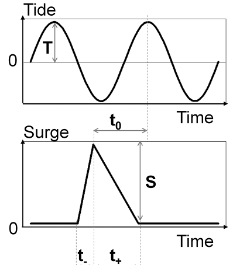

# Questions

1. Load the data and visualize the design of experiments. What kind of design is it? Can you identify it precisely? We color the points whether Area is > 0 (flooding) or not. Can you interpret the flooding zone?

From now on, we now work on the design points for which there is flooding. We split the data into train and test sets. For the training set, we create XtrainSet, a matrix of size nTrain x d, and YtrainSet an array containing the images, considered as vectors in dimension D = number of pixels. Idem for the test set.

2. Visualize the maps of the training set corresponding to the given subsample of 4 design points (and check that there is indeed a flooding in some zone).  

3. Do a principal components analysis (PCA) on the training set, without scaling the data (here it seems to work better). How many principal components seem useful? How should we select them in a machine learning framework (we will not do it here)? Visualize the first four principal components (PCs) as a map. Interpret them by remembering that a PC is a linear combination of the original variables.

4. We provide a PCA encoder that takes a map (viewed as a vector in dimension D) and builds all principal components. Similarly, we provide a PCA decoder that takes a number of PCs and reconstitute the map (the vector in dimension D). For verification, choose a map. Apply the PCA encoder, and the PCA decoder with $n_{PC} = 10$ PCs. Check that you reconstitue well the original map.

5. Estimate a kriging (= GP) model for each of the first 10 PCs. What kernel is used by default? Recall why we must use a $\texttt{multistart}$ in the hyperparameter estimation (here choose $\texttt{multistart = 50}$). Consider the 1st PC. Look at the estimated coefficients of the kernel, and explain why we can detect here the most influential variables. Study the validity of the model (function 'plot'). What's happening for the PC with order $\geq 4$? Is it a problem for the final prediction?

6. Compute the predictions on the test set, by computing the predictions of each GP and use the PCA decoder.  Choose a map of the test set. Visualize the predicted map and compare. We visualize the spatial errors over all the test set $T$, defined by
$$ \text{RMSE} = \left( \frac{1}{\vert T \vert} \sum_{i \in T} \Vert Y_i - \hat{Y}_i \Vert^2 \right)^{1/2}$$
where $Y_i$ is a map (D dim. vector) and $\hat{Y}_i$ is the predicted map. Comment the results.
We also compute the $Q^2$ criterion defined by
$$ Q^2 = 1 - \sum_{i \in T} \frac{\Vert Y_i - \hat{Y}_i \Vert^2}{\Vert Y_i - \bar{Y} \Vert^2}$$
where $\bar{Y}$ is the 'mean map' obtained by averaging over all maps (in the test set). Thus the $Q^2$ is equal to 1 if the prediction is perfect, 0 if it is as good as the mean, negative if worse.

Let us now perform a global sensitivity analysis (GSA). We assume that the 5 input variables are uniform and independent on $[0, 1]$. 

7. Let us consider the first PC. We do a GSA on the kriging mean. Estimate numerically the Sobol indices and total indices, using the function $\texttt{soboljansen}$ (R package $\texttt{sensitivity}$). What are the most influential inputs? The inactive ones? Are there interactions? Between which variables? Why can we deduce that there are no interactions of order 4 or 5 here? Same questions for the second PC.

8. To go further into details, estimate all the interactions up to order 3, using the functions $\texttt{sobol}$. Check that we do not miss higher order interaction terms, and explain how the results are consistent with the total effects estimated in the previous question. Same question for the second PC.

9. Compute the generalized sensitivity indices by considering the Sobol indices (including interactions up to order 3) of the first 3 PCs.

10. Consider again the first PC. We give a code to estimate the conditional mean of the toy function Ishigami. Adapt this code to visualize the main effects of the first PC for all the 5 input variables.

11. Assumption criticism. In the metamodeling phase, we have modeled *independently* each PC by a GP. Is this assumption justified here? Similarly, in the sensitivity analysis phase, we have assumed all input variables independent and uniform. Is this assumption correct?



# Starter

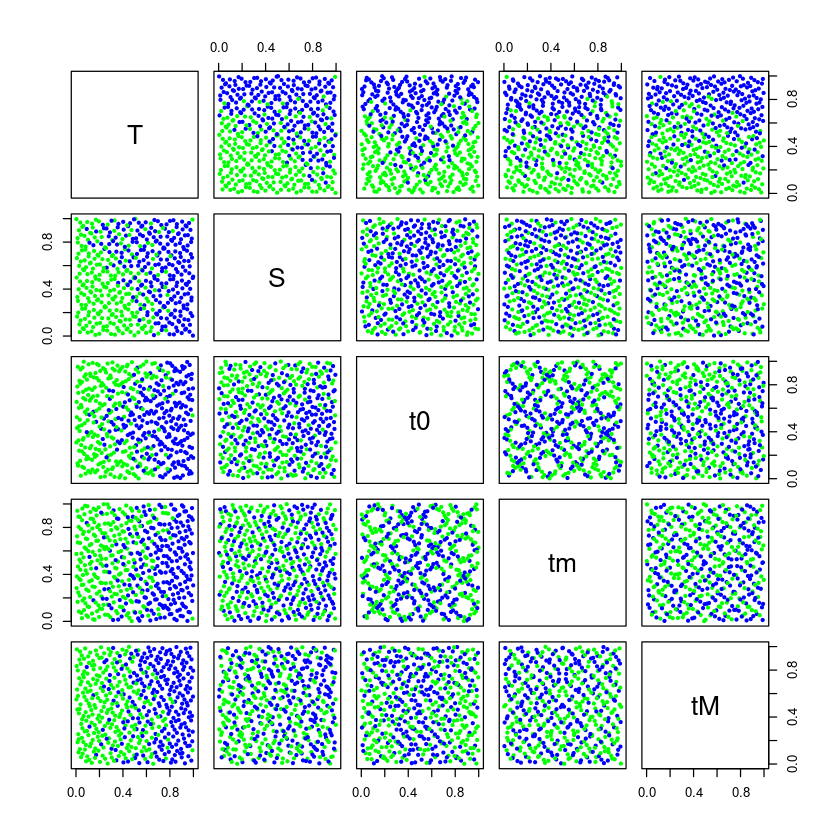

In [1]:
# Question 1 - Data loading and DoE 
rm(list = ls())
load("Boucholeurs_NOFailure.RData")

names(doe) <- c("T", "S", "t0", "tm", "tM") # shorter names

doeFull <- doe
HEFull <- HE

# design of experiments, with/without flooding
options(repr.plot.width = 7, repr.plot.height = 7)
pairs(doeFull, pch = 19, cex = 0.5,
      xlim = c(0, 1), ylim = c(0, 1),
      col = ifelse(Area > 0, "blue", "green"))

<div class="alert alert-block alert-info"> 
<b>1. Load the data and visualize the design of experiments. What kind of design is it? Can you identify it precisely? We color the points whether Area is > 0 (flooding) or not. Can you interpret the flooding zone? </b>
<br>
<br>
Le design est un DoE (plan d'expériences), et plus précisement un hypercube latin. On remarque que la variable T (amplitude de la marée) est une variable avec le plus d'influence car elle permet de distinguer les zones inondées. Les points en bleu représentent les zones inondées et les verts les zones non inondées. En général, lorsque l'amplitude de la marée est basse, il y a moins de risque d'inondations (en particulier par rapport aux variables tm et tM). De plus, il semble y avoir une relation affine entre T et S (pic de surcôte). Si le pic de surcôte est grand, alors il y aura plus d'inondations même si l'amplitude de la marée est basse.
</div>

Le chargement a nécessité le package : spam

Spam version 2.11-0 (2024-10-03) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attachement du package : ‘spam’


Les objets suivants sont masqués depuis ‘package:base’:

    backsolve, forwardsolve


Le chargement a nécessité le package : viridisLite


Try help(fields) to get started.



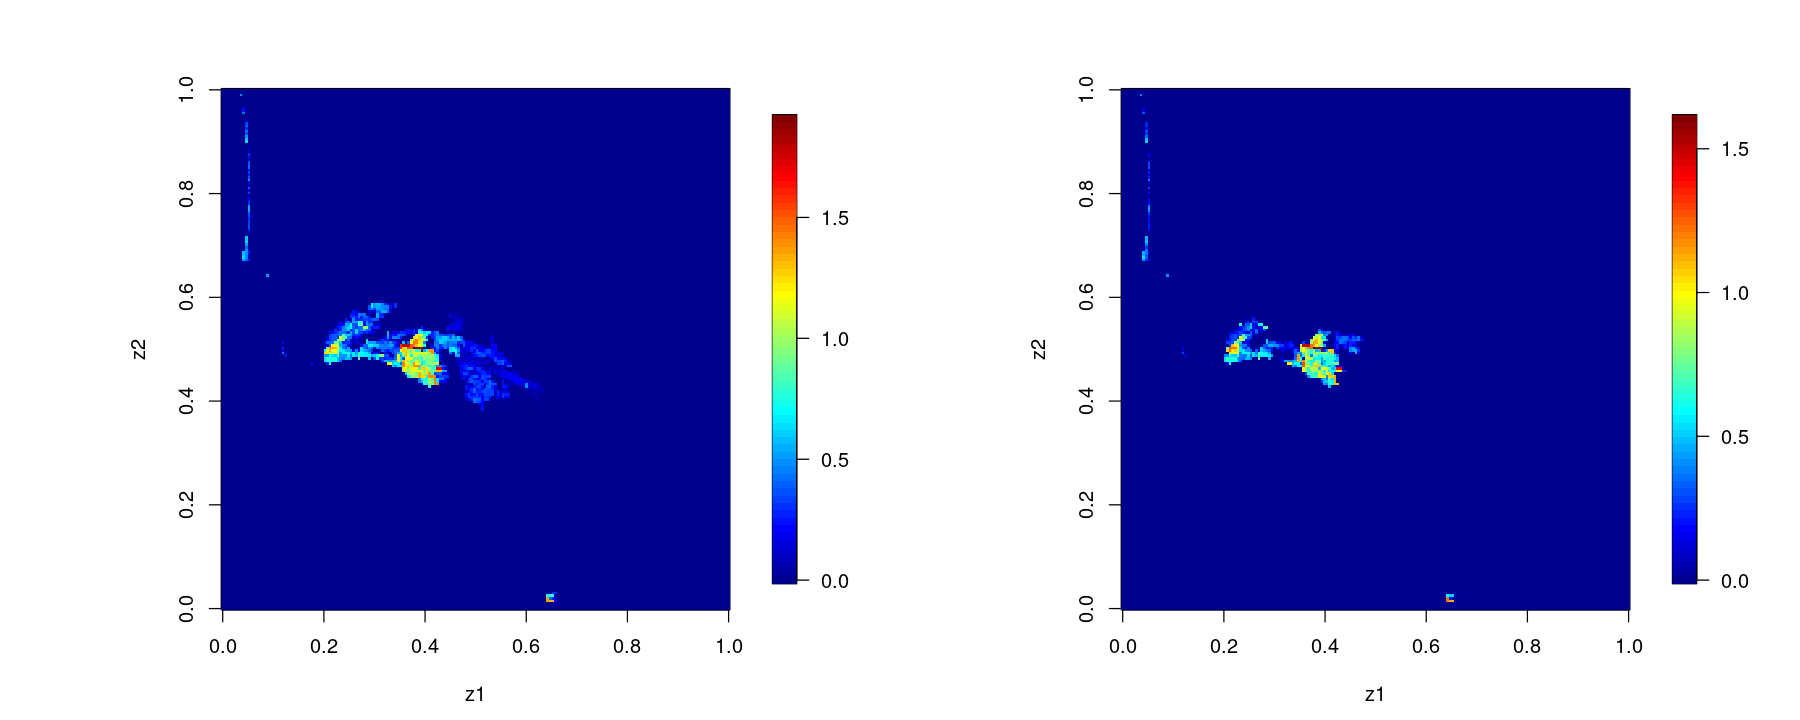

In [2]:
# In the sequel, we consider the subset of the DoE for which there has been flooding
inondOnly <- which(Area > 0)
doe <- doeFull[inondOnly, ]
HE <- HEFull[, , inondOnly]

# Utilities and maps visualization
# Map visualizations.
library(fields)

nGridx <- dim(HE)[1]
nGridy <- dim(HE)[2]

map2vec <- function(map){ 
  as.numeric(map) 
}
vec2map <- function(vec, nx = nGridx, ny = nGridy){ 
  matrix(vec, nrow = nx, ncol = ny)
}

z1 <- seq(from = 0, to = 1, length = nGridx)
z2 <- seq(from = 0, to = 1, length = nGridy)

par(mfrow = c(1, 2))
options(repr.plot.width = 15, repr.plot.height = 6)
for (i in 1:2){
  image.plot(z1, z2, HE[,,i], graphics.reset = TRUE)
}

In [3]:
# train and test set
n <- nrow(doe)
nTrain <- 150
nTest <- n - nTrain
set.seed(0)
indTrain <- sample(1:n, size = nTrain)
indTest <- setdiff(1:n, indTrain)

Xtrain <- doe[indTrain, ]
Xtest <- doe[-indTrain, ]

YtrainSet <- matrix(NA, nrow = nTrain, ncol = nGridx * nGridy)
YtestSet <- matrix(NA, nrow = nTest, ncol = nGridx * nGridy)

for (i in 1:nTrain){
  YtrainSet[i, ] <- map2vec(HE[, , indTrain[i]])
}
for (i in 1:nTest){
  YtestSet[i, ] <- map2vec(HE[, , indTest[i]])
}


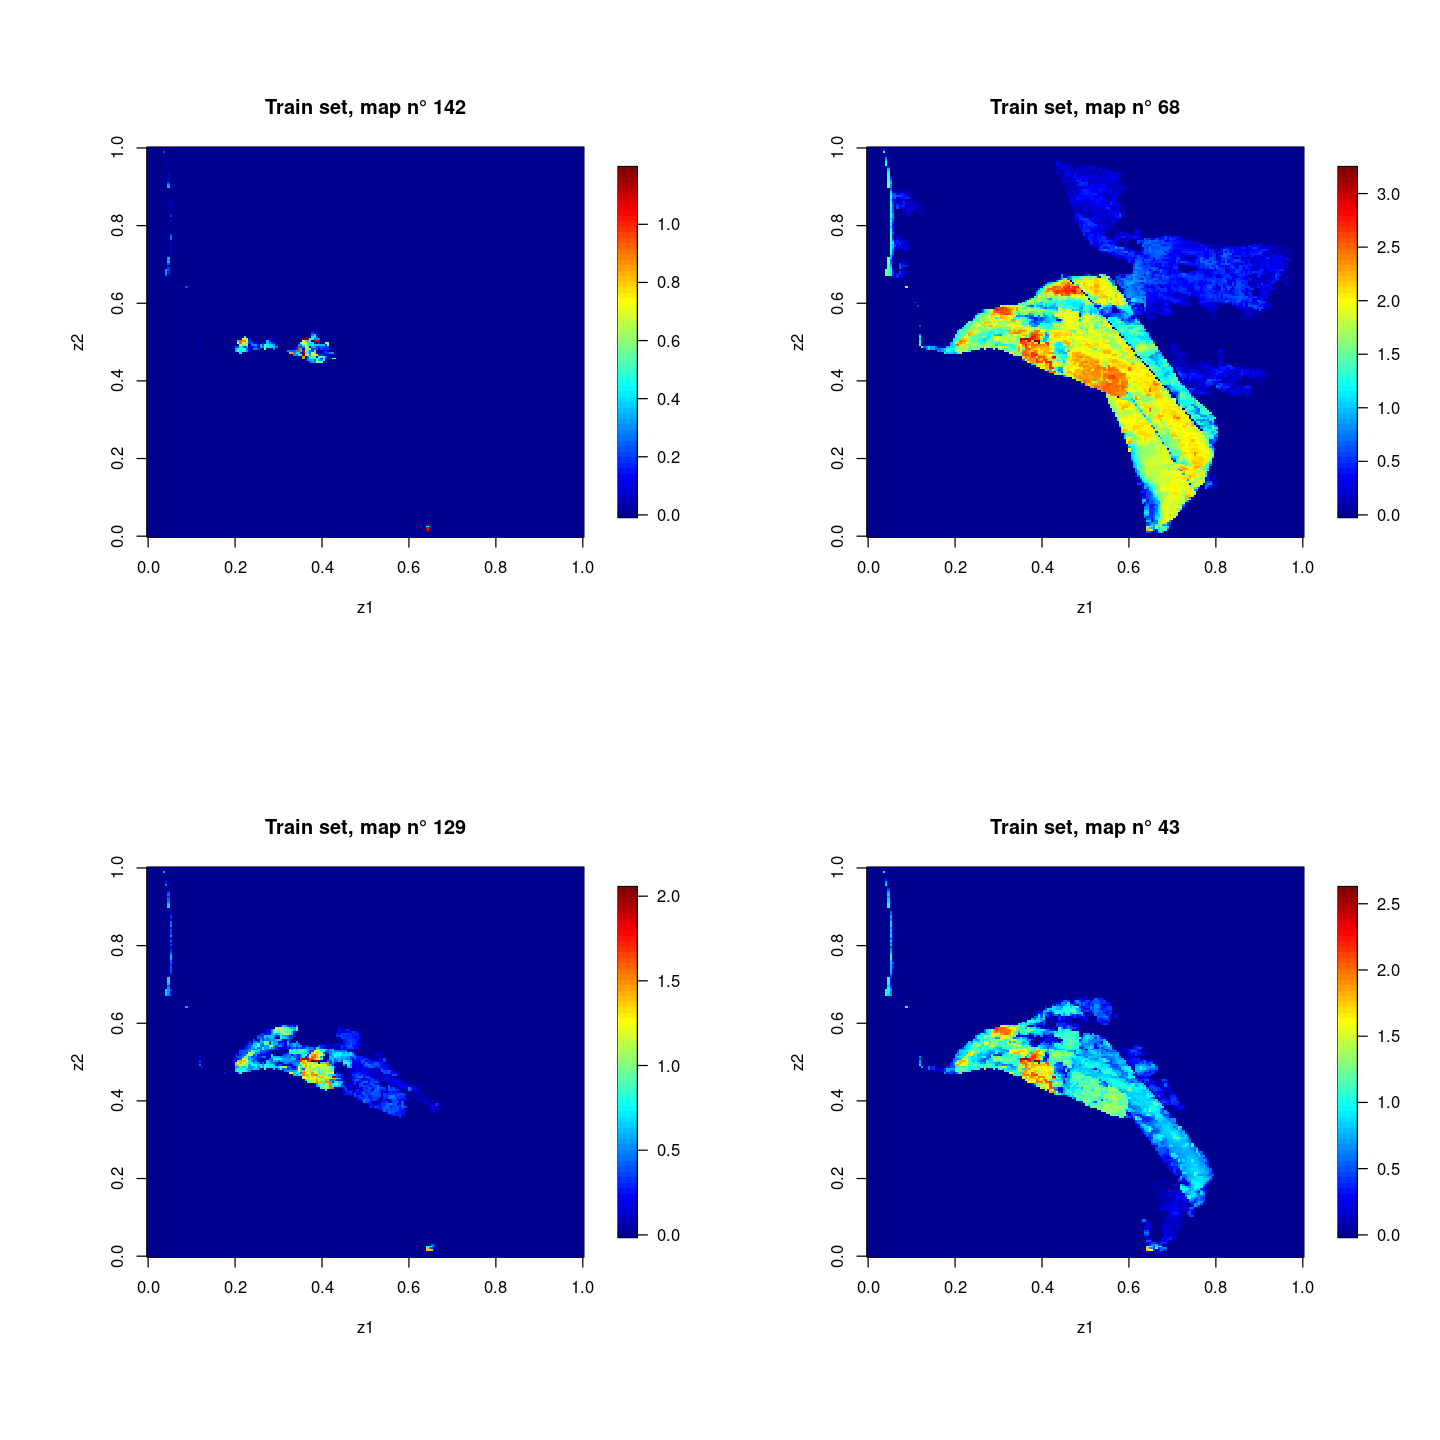

In [4]:
# Question 2
set.seed(0)
subsample <- sample(1:nTrain, 4)

par(mfrow = c(2, 2))
options(repr.plot.width = 12, repr.plot.height = 12)
for (i in 1:4){
  j <- subsample[i]
  image.plot(z1, z2, vec2map(YtrainSet[j, ]),    # map of the training set n°j
             main = paste("Train set, map n°", j),
             graphics.reset = TRUE)
}


<div class="alert alert-block alert-info"> 
<b>2. Visualize the maps of the training set corresponding to the given subsample of 4 design points (and check that there is indeed a flooding in some zone). </b>
<br>
<br>
On remarque qu'il y a deux zones qui sont souvent inondées, une qui se trouve à z1 = 0.4 et z2 = 0.5, et une autre grande zone qui ressemble à la côte.
</div>

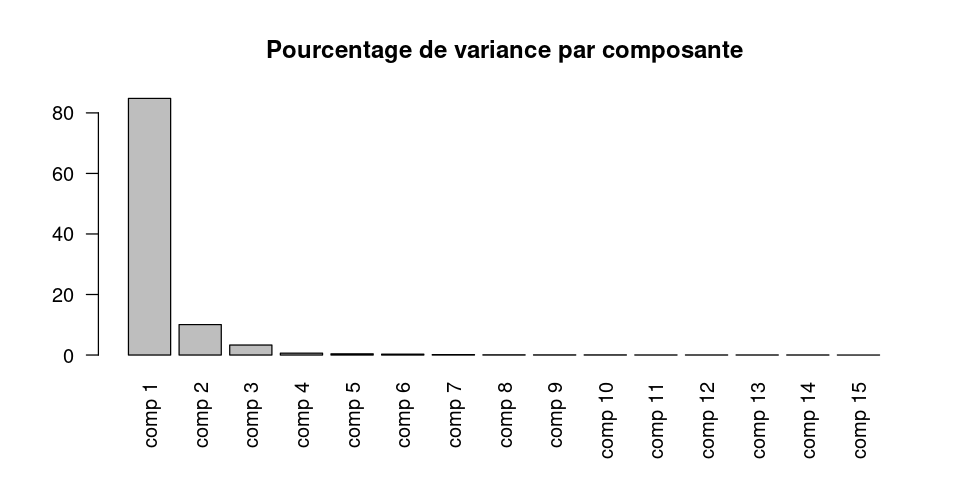

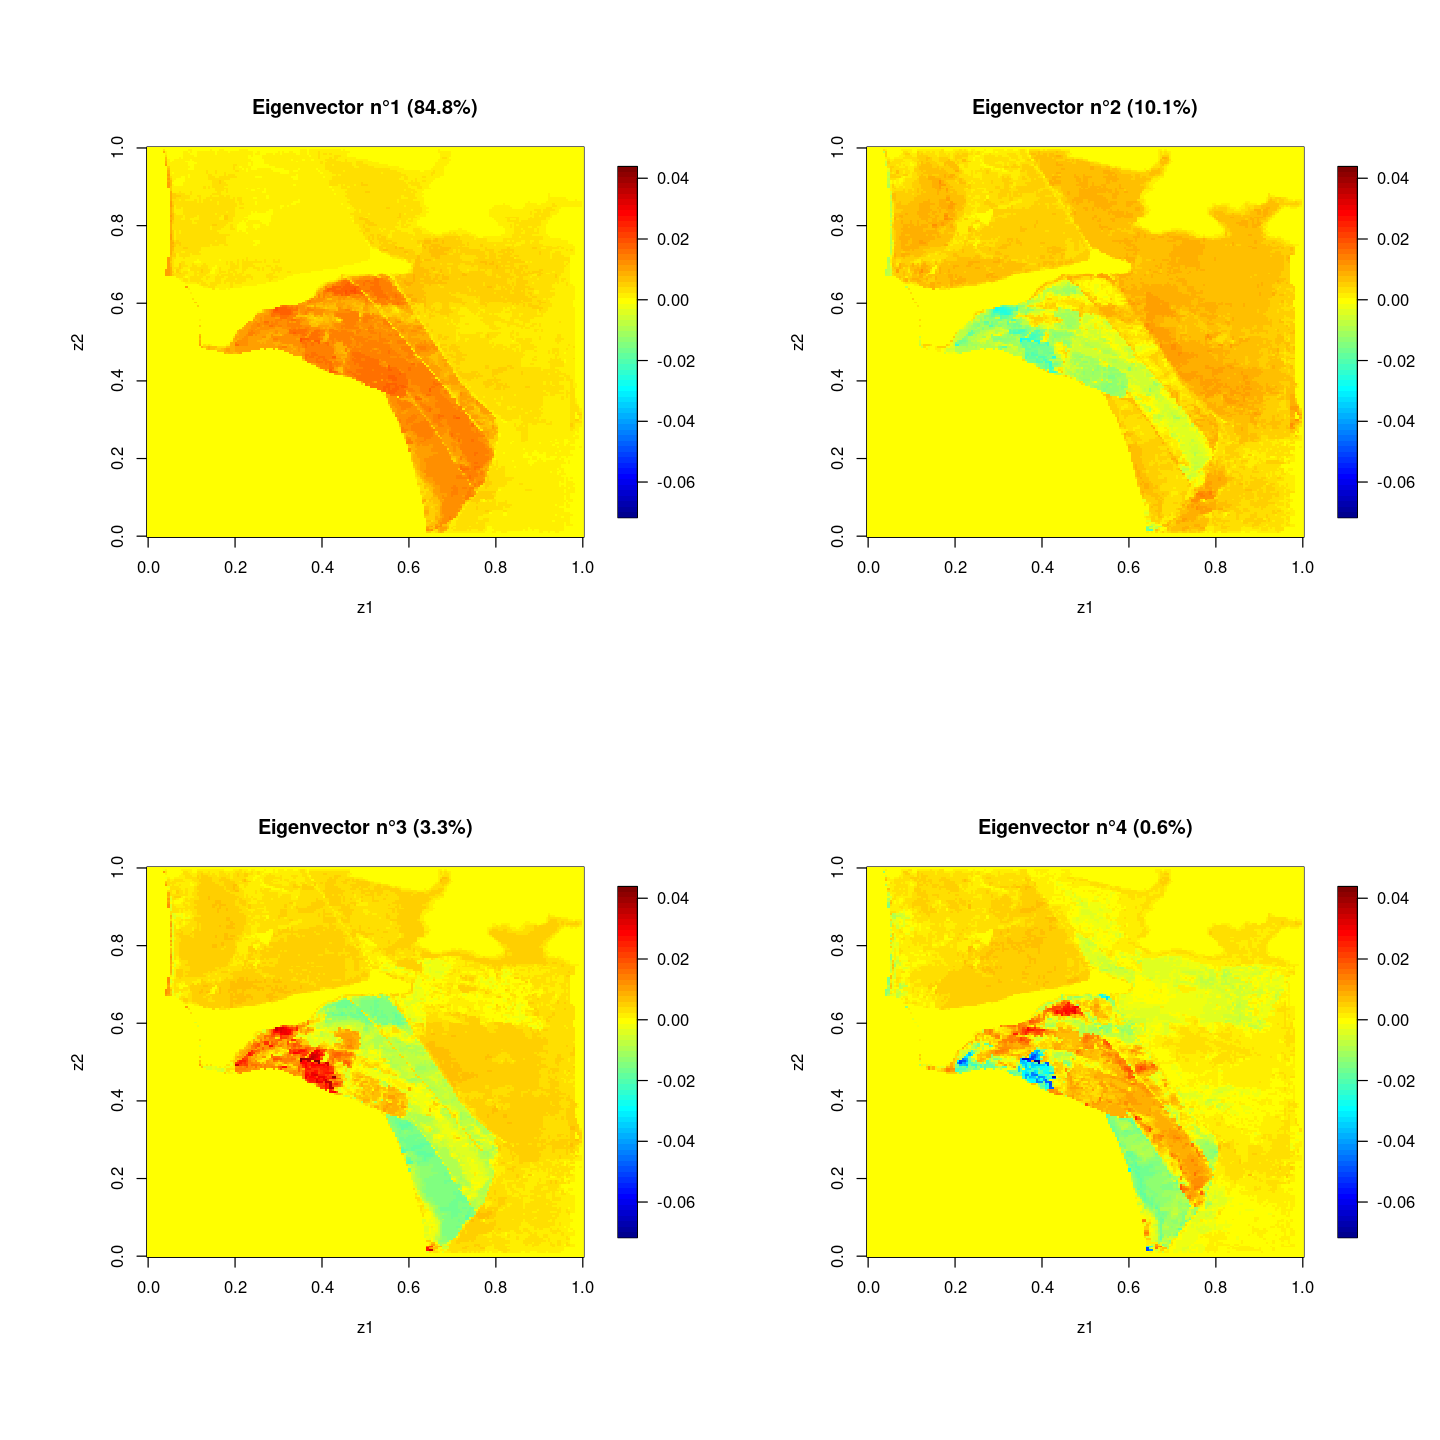

In [5]:
# Question 3
# PCA on trainSet
library(FactoMineR)

resPCA <- PCA(YtrainSet, graph = FALSE,     # PCA on the maps of the training set
              scale.unit = FALSE, ncp = 15)

par(mfrow = c(1, 1))
options(repr.plot.width = 8, repr.plot.height = 4)
barplot(resPCA$eig[1:15, 2], las = 2, main = "Pourcentage de variance par composante")

# visualization of the first eigenvectors, as maps
par(mfrow = c(2, 2))
options(repr.plot.width = 12, repr.plot.height = 12)
zlim = range(resPCA$svd$V[, 1:4])
for (j in 1:4){
  image.plot(z1, z2, vec2map(resPCA$svd$V[, j]), 
             zlim = zlim,
             main = paste("Eigenvector n°", j, " (", 
                          round(resPCA$eig[j, 2], 1),  "%)", sep = ""),
             graphics.reset = TRUE)
}


<div class="alert alert-block alert-info"> 
<b>3. Do a principal components analysis (PCA) on the training set, without scaling the data (here it seems to work better). How many principal components seem useful? How should we select them in a machine learning framework (we will not do it here)? Visualize the first four principal components (PCs) as a map. Interpret them by remembering that a PC is a linear combination of the original variables. </b>
<br>
<br>
En utilisant seulement deux composantes principales, nous parvenons à expliquer 94% de la variance totale des données. En ajoutant une troisième composante, ce pourcentage s'élève à 97%. Nous pouvons conserver 3 composantes pour être plus précis. Nous pouvons choisir nos composantes à l'aide d'une cross validation. En effet, en testant plusieurs combinaisons nous pouvons déterminer quelles composantes sont utiles à garder ou non.
<br>
<br>
Les 2 premières composantes principales capturent l'essentiel de l'information géographique, et les zones inondées ou à risque élevé semblent principalement représentées dans ces deux premières composantes. Plus précisement, le premier vecteur propre peut capturer la répartition générale de la hauteur d'eau, tandis que les vecteurs suivants capturent des motifs plus localisés ou complexes. En effet pour la première composante, les zones colorées en rouge correspondent à celles où les valeurs des données initiales sont les plus influentes. Dans notre cas, cela veut dire qu'en moyenne les inondations se trouvent dans la zone rouge. 
<br>
<br>
Pour la seconde composante principale, on remarque des corrélations positives et négatives (rouge et bleu) supposant que les différentes zones auraient des dynamiques contraires. Par exemple, une zone qui a plus tendance à être inondée, ou alors lorsqu'il y a une faible inondation dans une zone, il y a une forte inondation dans l'autre.
<br>
<br> 
La 3ème composante principale capture des variations encore plus spécifiques et de moindre importance. Les zones en rouge et bleu indiquent des caractéristiques géographiques plus petites ou des variations fines dans les données. Par exemple, des micro-zones inondées ou des zones à risque localisé (zone z1 = 0.4 et z2 = 0.5).
    <br>
<br>
Enfin, la 4ème composante principale capture des variations très spécifiques et mineures, probablement des détails ou des anomalies locales.
</div>

[1] 3.189613e-23

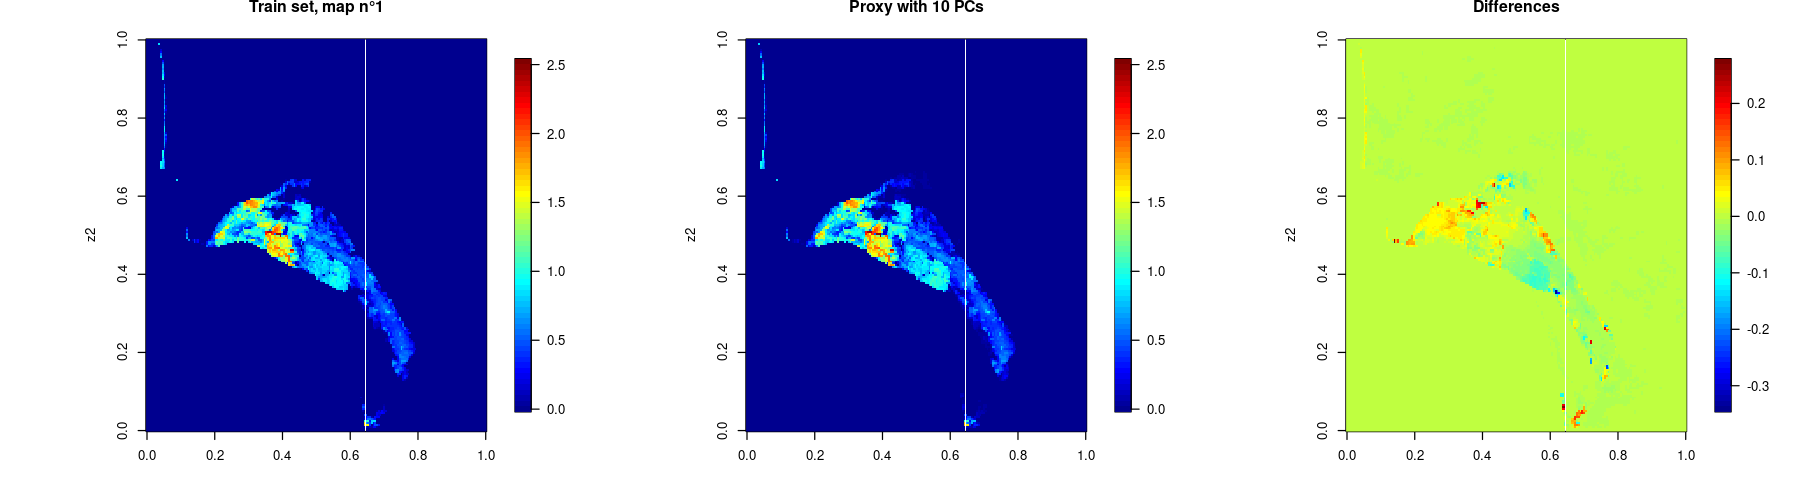

In [6]:
# Question 4
PCAencoder <- function(dataset, PCAmodel){
  # takes a dataset whose rows are vector in R^p and returns the PC coordinates 
  # notice that the vector is first centered and scaled (if scale.unit = TRUE in PCAmodel)
  vect <- scale(dataset, 
                center = PCAmodel$call$centre, 
                scale = PCAmodel$call$ecart.type)
  return(vect %*% PCAmodel$svd$V)
}

# test for PCAencoder
PCcoord <- PCAencoder(YtrainSet, PCAmodel = resPCA)
sum((resPCA$ind$coord - PCcoord)^2)  # should be zero

PCAdecoder <- function(PCcoord, PCAmodel){
  # takes a matrix whose rows are PC coordinates
  # and express it in the original space R^q
  # notice that data are scaled back and centered back
  nPC <- ncol(PCcoord)
  res <- PCcoord %*% t(PCAmodel$svd$V[, 1:nPC])
  for (i in 1:nrow(res)){
    res[i, ] <- res[i, ] * PCAmodel$call$ecart.type + PCAmodel$call$centre
  }
  # here the result should be non-negative
  res <- pmax(res, 0)
  return(res)
}

# compute PC coordinates (apply the PCA encoder)
PCcoord <- PCAencoder(YtrainSet, resPCA)  
# reconstitute the images from the first nPC coordinates (apply the PCA decoder)
nPC <- 10
YtrainSetProxy <- PCAdecoder(PCcoord[,1:nPC], resPCA)

# test
par(mfrow = c(1, 3))
options(repr.plot.width = 15, repr.plot.height = 4)
zlim <- range(c(YtrainSet[1, ], YtrainSetProxy[1, ]))
image.plot(z1, z2, zlim = zlim, vec2map(YtrainSet[1, ]), 
           main = "Train set, map n°1", 
           graphics.reset = TRUE)
image.plot(z1, z2, zlim = zlim, vec2map(YtrainSetProxy[1, ]),
           main = paste("Proxy with", nPC, "PCs"), 
           graphics.reset = TRUE)
image.plot(z1, z2, vec2map(YtrainSet[1, ] - YtrainSetProxy[1, ]),
           main = paste("Differences"), 
           graphics.reset = TRUE)



<div class="alert alert-block alert-info"> 
<b>4. We provide a PCA encoder that takes a map (viewed as a vector in dimension D) and builds all principal components. Similarly, we provide a PCA decoder that takes a number of PCs and reconstitute the map (the vector in dimension D). For verification, choose a map. Apply the PCA encoder, and the PCA decoder with $n_{PC} = 10$ PCs. Check that you reconstitue well the original map.</b>
<br>
<br>
En observant les images ci dessus, on constate que la reconstruction a bien fonctionné. Il y a quelques différences, au niveau des zones souvent inondées, mais qui sont mineures.
</div>

In [7]:
# Question 5
GPlist <- list()  # the GP models for each selected PCsgbgt will be stored in this list

library(DiceKriging)
require(foreach)

# fit a kriging model for the first nPC principal components
require(doParallel)
nCores <- detectCores() - 1
cl <-  makeCluster(nCores) 
registerDoParallel(cl)

nPC <- 10 # just to start: to be increased !!!
for (j in 1:nPC){
  GPlist[[j]] <- km(design = Xtrain, response = PCcoord[,j], 
                    multistart = 50)
}

stopCluster(cl)

Le chargement a nécessité le package : foreach

Le chargement a nécessité le package : doParallel

Le chargement a nécessité le package : iterators

Le chargement a nécessité le package : parallel




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  1.8125 1.972656 1.964844 1.976562 1.980469 
  - best initial criterion value(s) :  -631.7748 -642.4105 -653.2486 -665.2105 -669.4121 -686.7555 -691.1419 -694.3887 -695.1599 -695.6791 -702.2331 -703.9092 -704.4663 -711.0811 -716.9168 -720.9244 -732.5283 -732.6917 -733.7813 -741.4654 -742.3296 -742.7246 -743.1153 -743.5764 -747.3198 -748.1333 -752.9177 -757.7916 -759.7134 -759.8513 -760.6196 -764.2176 -770.7217 -772.1399 -774.6188 -778.1626 -785.2071 -787.3838 -791.9238 -794.162 -794.6298 -795.2419 -799.5628 -806.1262 -806.1458 -807.509 -809.7818 -811.0931 -830.7225 -843.5691 


* The 50 best values (multistart) obtained are:
 614.2168 614.2168 614.2168 614.2168 614.2168 614.2168 614.2168 614.


Call:
km(design = Xtrain, response = PCcoord[, j], multistart = 50)

Trend  coeff.:
               Estimate
 (Intercept)    28.4018

Covar. type  : matern5_2 
Covar. coeff.:
               Estimate
    theta(T)     0.5423
    theta(S)     0.8743
   theta(t0)     0.2916
   theta(tm)     1.4821
   theta(tM)     1.3180

Variance estimate: 4753.416


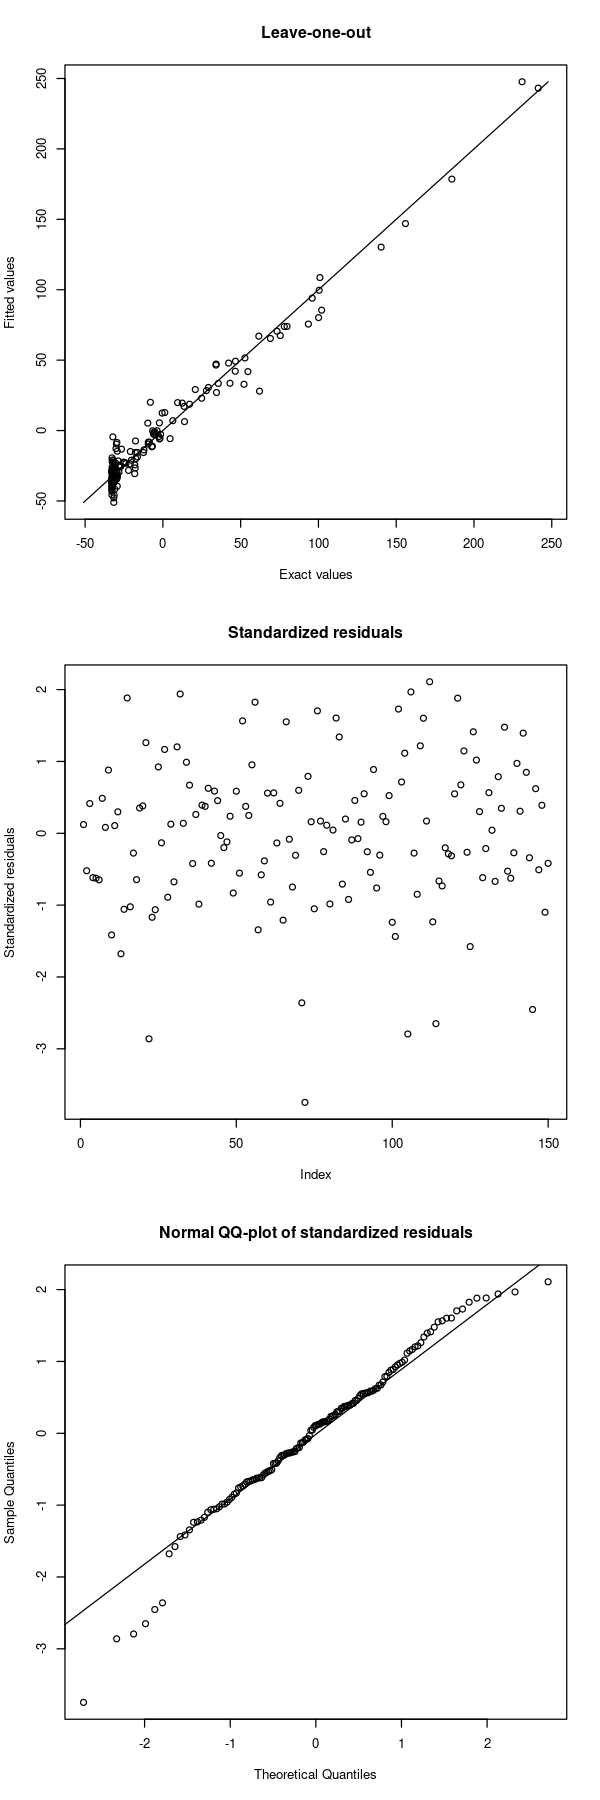

In [8]:
# print results 
print(GPlist[[1]])  # example for the first GP model

# quality of GP models
options(repr.plot.width = 5, repr.plot.height = 15)
plot(GPlist[[1]])

<div class="alert alert-block alert-info"> 
<b>5. Estimate a kriging (= GP) model for each of the first 10 PCs. What kernel is used by default? Recall why we must use a $\texttt{multistart}$ in the hyperparameter estimation (here choose $\texttt{multistart = 50}$). Consider the 1st PC. Look at the estimated coefficients of the kernel, and explain why we can detect here the most influential variables. Study the validity of the model (function 'plot'). What's happening for the PC with order $\geq 4$? Is it a problem for the final prediction? </b>
<br>
<br>
Le kernel par défaut est le matern 5/2. Le multistart permet s'assurer que l'optimisation des hyperparamètres soit bien orientée vers le maximum global, garantissant ainsi des performances robustes et fiables de notre modèle. Dans notre cas, on relance l'optimisation 50 fois pour chaque composante à partir de points différents à chaque fois.
<br>
<br>
Lorsque l'on considère la première composante, le modèle nous retournent des coefficients de kernel qui nous permettent de détecter les variables les plus influentes. En effet, coefficients de kernel correspondent la portée spatiale à laquelle les observations dans cette dimension sont corrélées. Ainsi une valeur de theta plus petite signifie que la sortie varie rapidement en fonction de la variable (effet local), tandis qu'une valeur plus grande signifie que la sortie varie plus lentement. Donc les variables qui sont les plus influentes sont t0 et T car theta(t0)=0.29 et theta(T)=0.54.
<br>
<br>
Le modèle semble fonctionner raisonnablement bien dans l'ensemble, avec des prédictions proches des valeurs réelles. Cependant, les deux premier graphiques révèlent quelques problèmes potentiels, notamment une dispersion aux extrêmes dans le graphique de la validation croisée et quelques points influents dans les résidus standardisés. Cela suggère que le modèle pourrait avoir des difficultés à bien prédire certaines observations atypiques. Le QQ-plot montre que, bien que les résidus standardisés suivent raisonnablement une distribution normale dans leur majorité (écarts aux extrémités).
<br>
<br>
Lorsque nous observons les PC supérieures à 4 (voir ci dessous), nous observons que les modèles de krigreage n'est plus du tout valide. Les résidus ne suivent plus une loi normale et les prédictions sont loins des valeurs réelles. Cependant, ce n'est pas très grave pour les prédictions finales car les dernières composantes ne possèdent pas beaucoup d'informations (faible variance) donc cela n'aura pas une grande influence sur le résultat final.
</div>

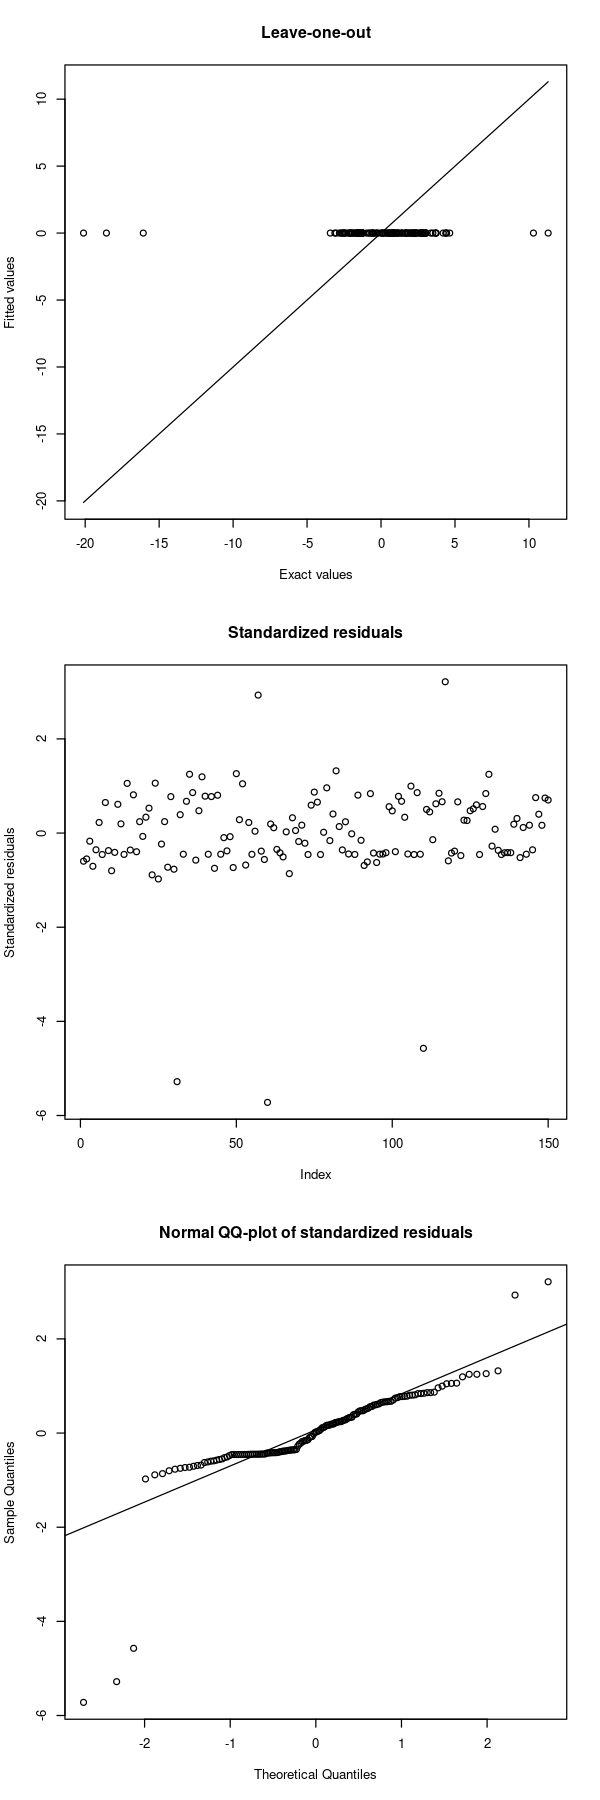

In [9]:
plot(GPlist[[5]])

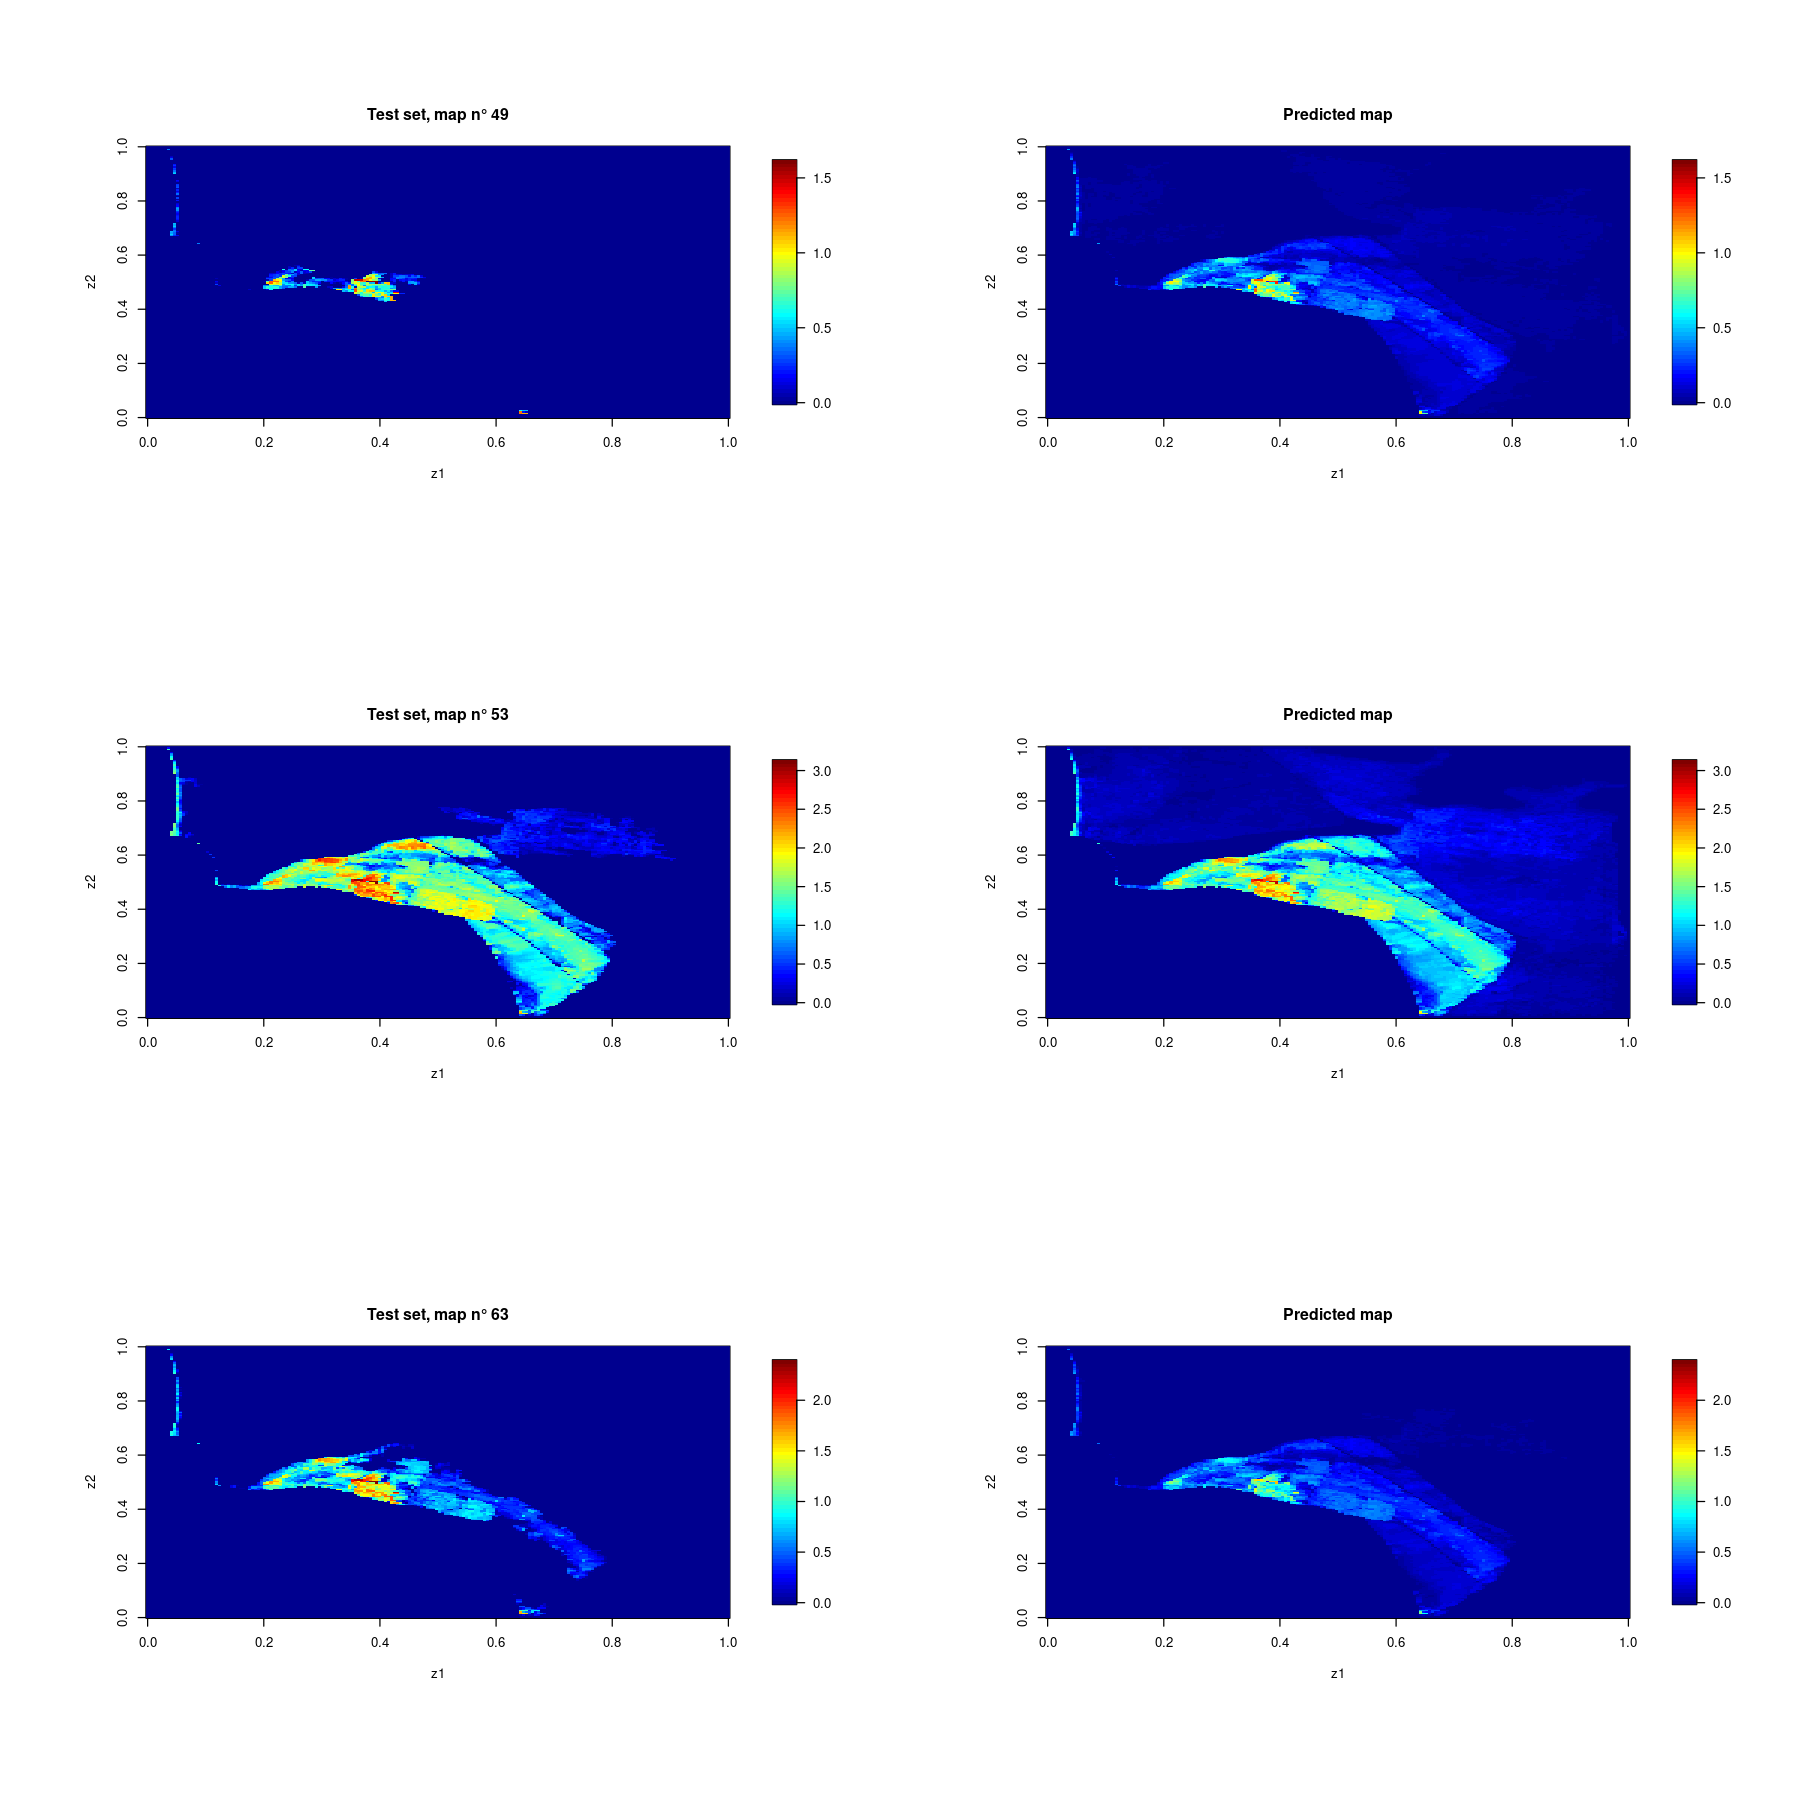

In [10]:
# question 6
# compute predictions
GPpred <- matrix(NA, nrow = nTest, ncol = nPC)
for (j in 1:nPC){
    # prediction for each PC
    GPpred[, j] <- predict(GPlist[[j]], newdata = Xtest, 
                           checkNames = FALSE, type = "UK")$mean
}

# deduce the prediction on the image with the PCA decoder
YtestSetGPpred <- PCAdecoder(GPpred, resPCA)


# test
par(mfrow = c(3, 2))
options(repr.plot.width = 15, repr.plot.height = 15)
for (i in 1:3){
  j <- sample(1:nTest, 1)
  zlim <- range(c(YtestSet[j, ], YtestSetGPpred[j, ]))
  image.plot(z1, z2, zlim = zlim, vec2map(YtestSet[j, ]), 
             main = paste("Test set, map n°", j),
             graphics.reset = TRUE)
  image.plot(z1, z2, zlim = zlim, vec2map(YtestSetGPpred[j, ]),
             main = "Predicted map", 
             graphics.reset = TRUE)
}


Q2 =  0.9488348 


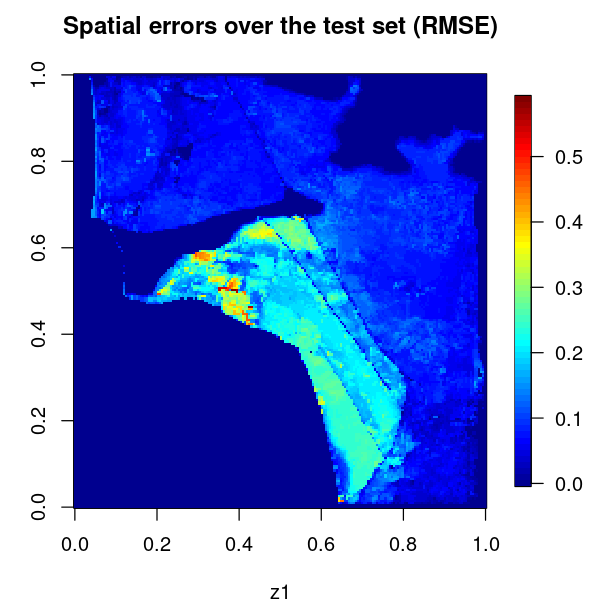

In [11]:
# Question 6 (continued)
# computation of the spatial error 
spatialMSE <- function(obs, pred){
  colMeans((obs - pred)^2)  
}

RMSE <- sqrt(spatialMSE(YtestSet, YtestSetGPpred))
par(mfrow = c(1, 1))
options(repr.plot.width = 5, repr.plot.height = 5)
image.plot(z1, z2, zlim = c(0, max(RMSE)), 
           matrix(RMSE, nrow = nGridx, ncol = nGridy),
           main = "Spatial errors over the test set (RMSE)",
           graphics.reset = TRUE)

Q2 <- function(obs, pred){
  sampleMean <- colMeans(obs) # naive prediction by the sample mean
  Q2num <- mean(spatialMSE(obs, pred))
  Q2denum <- mean(spatialMSE(obs, sampleMean))
  return(1 - Q2num / Q2denum)

}

cat("Q2 = ", Q2(YtestSet, YtestSetGPpred), "\n")

<div class="alert alert-block alert-info"> 
<b>6. Compute the predictions on the test set, by computing the predictions of each GP and use the PCA decoder.  Choose a map of the test set. Visualize the predicted map and compare.</b>
<br>
<br>
En observant les images ci dessus, on constate que les prédictions sont assez semblables aux cartes initiales. De plus, nous avons une valeur du Q2 proche de 1 donc les prédictions sont bonnes.
La carte du RMSE montre les zones avec les plus grandes erreurs de prédiction, particulièrement dans les régions à forte variance d'inondation. Cela s'explique par le fait que dans ces zones, lorsque le modèle se trompe, l'erreur est plus grande en raison de la grande variabilité des inondations. Ainsi, les zones à forte variance ont tendance à présenter des erreurs de prédiction plus élevées, même si la fréquence des erreurs n'est pas nécessairement plus élevée.
</div>

Registered S3 method overwritten by 'sensitivity':
  method    from 
  print.src dplyr



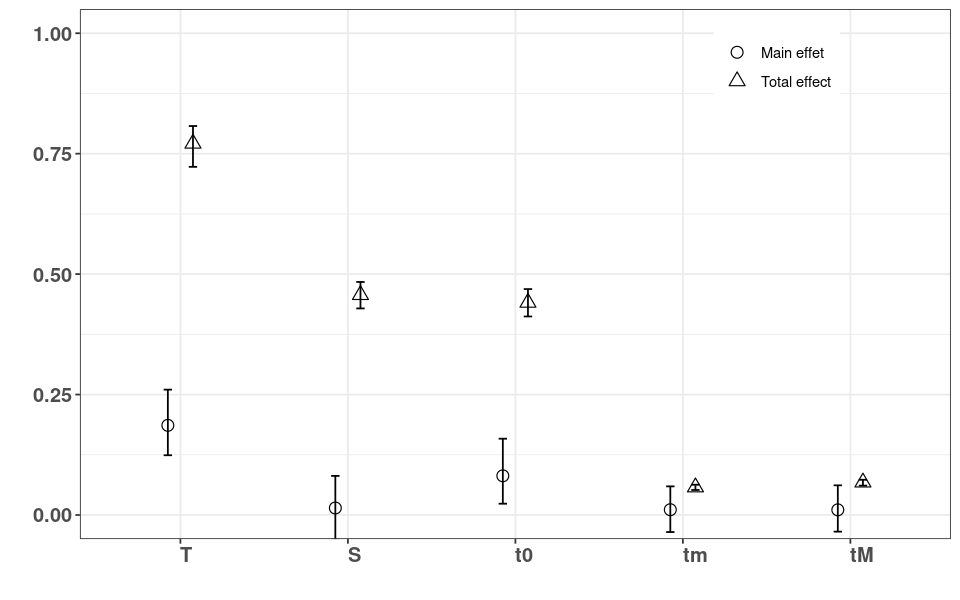

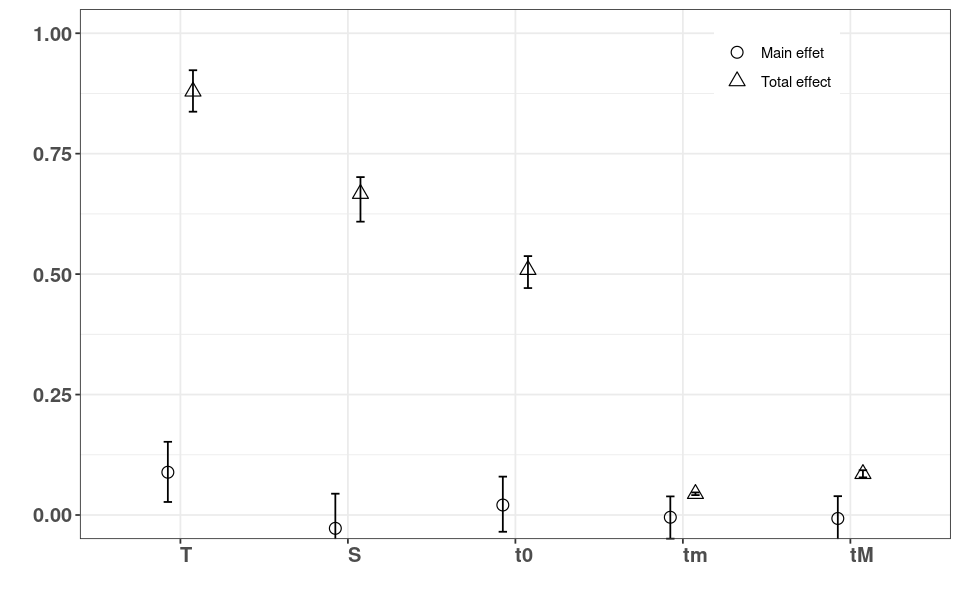

In [12]:
# Question 7
library(sensitivity)
library(ggplot2)

N <- 10000 # size of the simulation sample
d <- ncol(doe)
X1 <- matrix(runif(N*d), nrow = N, ncol = d)  # a matrix of size N*d containing simulations from the uniform distribution
X2 <- matrix(runif(N*d), nrow = N, ncol = d) # a second matrix of size N*d containing other (independent) simulations from the uniform distribution
X1 <- data.frame(X1); names(X1) <- names(doe)
X2 <- data.frame(X2); names(X2) <- names(doe)

# GSA on the first principal components
nPC_for_SA <- 2

# Wrapper for sensitivity analysis
krigingMean <- function(Xnew, m){
  predict.km(m, Xnew, "UK", se.compute = FALSE, 
             checkNames = FALSE)$mean
}

SA_GP <- list()
sobolIndexGP <- matrix(NA, nrow = nPC_for_SA, ncol = d)
totalIndexGP <- matrix(NA, nrow = nPC_for_SA, ncol = d)
colnames(sobolIndexGP) <- colnames(totalIndexGP) <- names(doe)

for (j in 1:nPC_for_SA){
  mySA_GP <- soboljansen(model = krigingMean, X1, X2, nboot = 100, 
                    m = GPlist[[j]])
  totalIndexGP[j, ] <- mySA_GP$T$original
  sobolIndexGP[j, ] <- mySA_GP$S$original
  SA_GP[[j]] <- mySA_GP
}

options(repr.plot.width = 8, repr.plot.height = 5)

ggplot(SA_GP[[1]], main = 'PC1')
ggplot(SA_GP[[2]], main = 'PC2')


<div class="alert alert-block alert-info"> 
<b>7. Let us consider the first PC. We do a GSA on the kriging mean. Estimate numerically the Sobol indices and total indices, using the function $\texttt{soboljansen}$ (R package $\texttt{sensitivity}$). What are the most influential inputs? The inactive ones? Are there interactions? Between which variables? Why can we deduce that there are no interactions of order 4 or 5 here? Same questions for the second PC.</b>
<br>
<br>
Pour la première composante, on constate que les entrées ayant le plus d'influences sont T, S et t0. Au contraire, les entrées ayant le moins d'influence sont tm et tM. Il y a des interactions au moins d'ordre 2. Par exemple, pour la variable T, l'indice total est bien plus élevé que l'indice individuel, cela signifie qu'il y a des interactions. C'est le cas aussi pour S et t0. Ces 3 entrées doivent interagir entre elles. Donc nous n'avons pas une fonction addictive. Cependant, il n'y a pas d'interactions d'ordre 4 ou 5 car les indices totaux de tm et tM sont faibles et proche de leur indice individuel.
<br>
<br>
Les résultats obtenus pour la deuxième composante principale sont les mêmes.</div>

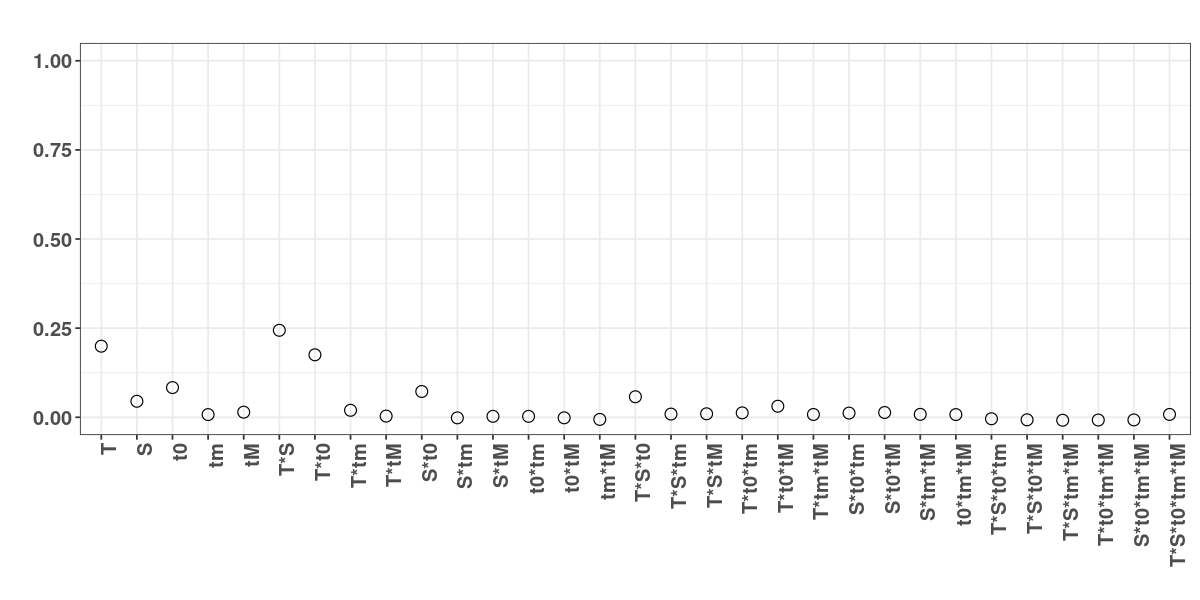

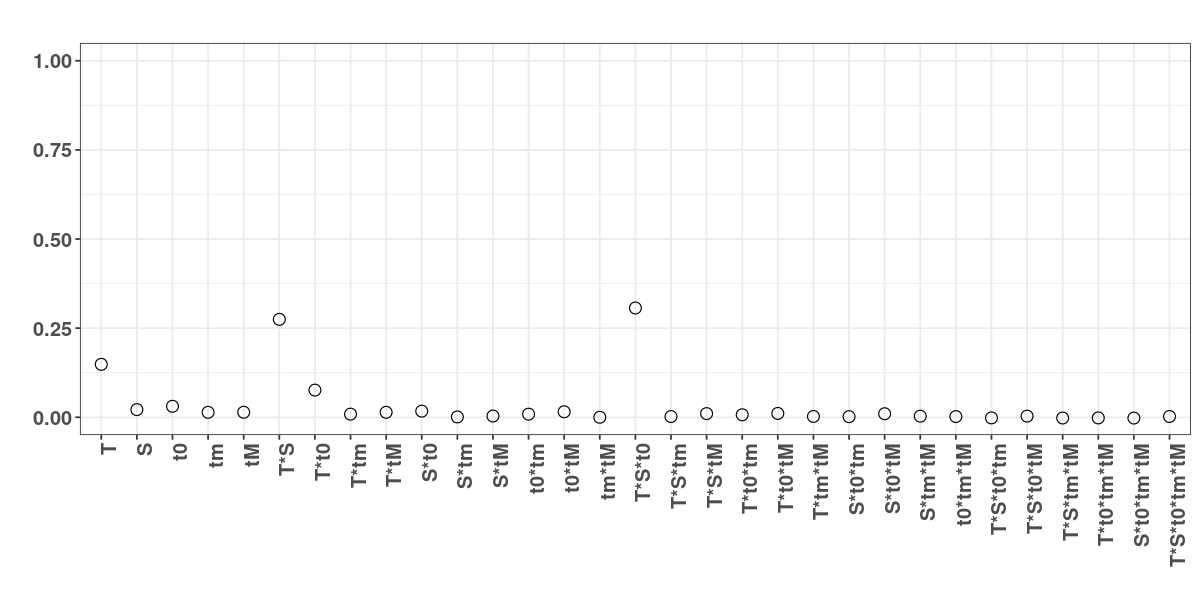

In [13]:
# Question 8
SA2_GP <- list()
order <- 5
sobolIndex2_GP <- matrix(NA, nrow = nPC_for_SA, ncol = 31)

for (j in 1:nPC_for_SA){
  mySA_GP <- sobol(model = krigingMean, X1, X2, order = order, m = GPlist[[j]])
  sobolIndex2_GP[j, ] <- mySA_GP$S$original
  SA2_GP[[j]] <- mySA_GP
}

par(mfrow = c(1, 1))
options(repr.plot.width = 10, repr.plot.height = 5)
ggplot(SA2_GP[[1]])
ggplot(SA2_GP[[2]])

<div class="alert alert-block alert-info"> 
<b>8. To go further into details, estimate all the interactions up to order 3, using the functions $\texttt{sobol}$. Check that we do not miss higher order interaction terms, and explain how the results are consistent with the total effects estimated in the previous question. Same question for the second PC.</b>
<br>
<br>
Pour la première composante principale, les variables les plus influentes sont T, S, et t0. Ces dernières jouent un rôle central dans la variation de la première composante, comme révélé par les indices de Sobol. 
<br>
<br>
    
Les interactions d'ordre 2, qui sont T\*S, T\*t0, S\*t0. T*S montrent une forte interaction.

On observe également une interaction d'ordre 3, qui est  T * S * t0. Elle indique que l'effet combiné des trois variables dépasse les effets individuels et les interactions d'ordre 2, ce qui reflète une dynamique complexe entre ces trois variables dans la prédiction de PC1. 

On remarque qu'il n'y a pas d'interactions d'ordre 4 ou 5, principalement parce que les variables tm et tM ont des indices totaux faibles. Cela signifie que ces variables n'interagissent pas de manière significative avec les autres variables et n'ont que peu d'influence sur PC1.

De même, pour la seconde composante, il y a T, T\*S, T\*t0, S\*t0 et  surtout la triple interaction T\*S\*t0. De plus  T\*S indique une relation non additive entre ces deux variables. Cela signifie que l'effet conjoint de T et S est plus important que la somme de leurs effets individuels.

En conclusion, les interactions jusqu'à l'ordre 3 révèlent que les variables T, S, et t0 sont les plus influentes et qu'elles interagissent fortement entre elles pour les deux premières composantes principales. Les interactions d'ordre 2 (comme T * S, T * t0) et d'ordre 3 (T * S * t0) sont particulièrement importantes, confirmant que le modèle n'est pas additif. Cependant, il n'y a pas d'interactions d'ordre 4 ou 5, ce qui est cohérent avec les faibles indices totaux observés pour tm et tM.

</div>

In [27]:
SA2_GP <- list()
order <- 3
nPC_for_SA <- 3 
sobolIndex2_GP <- matrix(NA, nrow = nPC_for_SA, ncol = 25)

for (j in 1:nPC_for_SA){
  mySA_GP <- sobol(model = krigingMean, X1, X2, order = order, m = GPlist[[j]])
  sobolIndex2_GP[j, ] <- mySA_GP$S$original
  SA2_GP[[j]] <- mySA_GP
}


[1] 1.105944


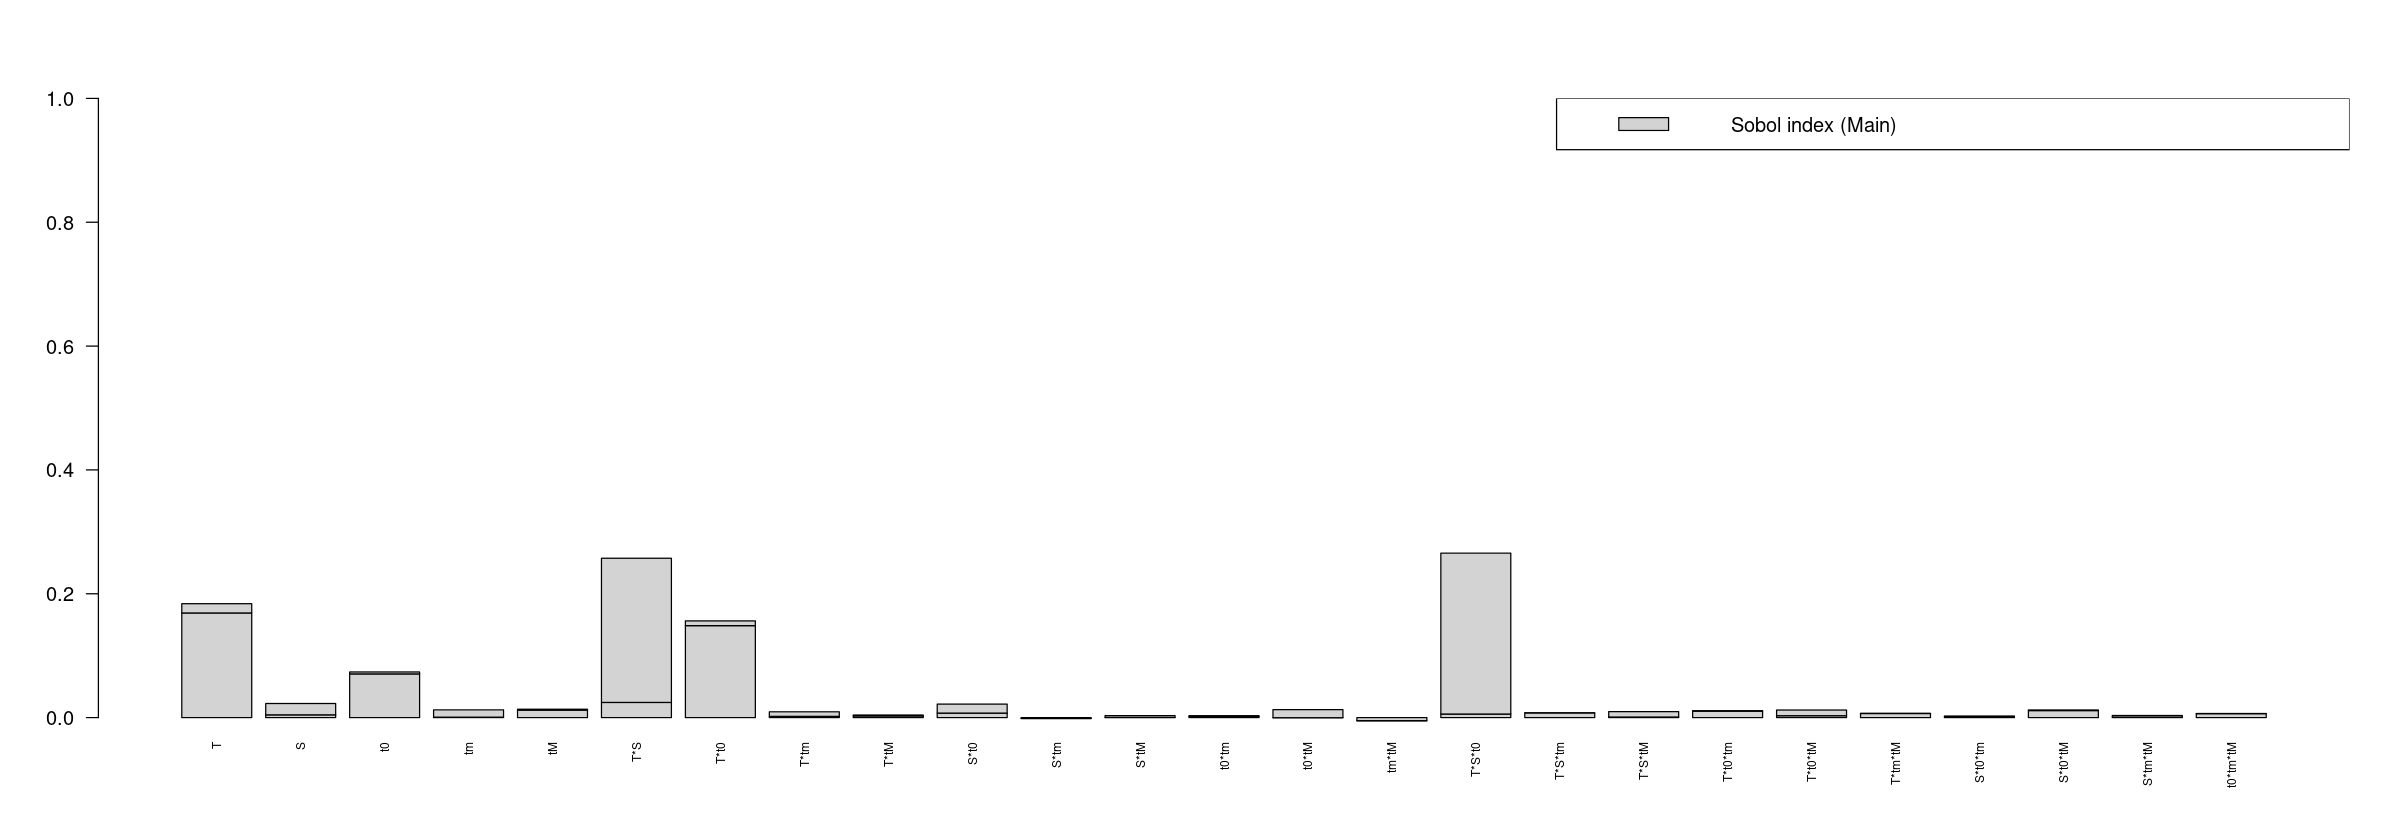

In [30]:
# question 9
# generalized sensitivity index
eigenvalProp <- resPCA$eig[1:3, 2]/100   # PCA eigenvalues (percentages)

sobolIndex2_GP_GSI <- t(t(sobolIndex2_GP[1:2, ]) * eigenvalProp[1:2]) # to be deduced from sobolIndex2_GP

colnames(sobolIndex2_GP_GSI) <- rownames(SA2_GP[[1]]$S)
par(mfrow = c(1, 1))
colMain <- "lightgrey"
colTotal <- "blue"
barplot(sobolIndex2_GP_GSI, ylim = c(0, 1), col = colMain, 
        cex.names = 0.6, las = 2)
legend("topright", legend = "Sobol index (Main)", fill = colMain)
print(sum(sobolIndex2_GP_GSI))

<div class="alert alert-block alert-info"> 
<b>9. Compute the generalized sensitivity indices by considering the Sobol indices (including interactions up to order 3) of the first 3 PCs.</b>
<br>
<br>
La somme des indices de Sobol généralisés, pondérés par les valeurs propres des composantes principales, est égale à 1.105944, donc proche de 1. Cela indique que les contributions cumulées des variables dans le modèle expliquent presque toute la variabilité des premières composantes principales. Cela signifie que la plupart des informations importantes sont capturées par les variables incluses dans le modèle.
<br> 
<br>
T, T*S, T*t0 et T*S*t0 semblent avoir des contributions importantes. Ils ont des barres nettement plus élevées que les autres variables, indiquant qu'ils influencent significativement les premières composantes principales. t0 est également non négligeable, mais avec une contribution plus modérée.
La majorité des autres variables ont des contributions proches de zéro, suggérant qu'elles n'ont que peu ou pas d'impact sur la variance capturée par les premières composantes principales.
</div>

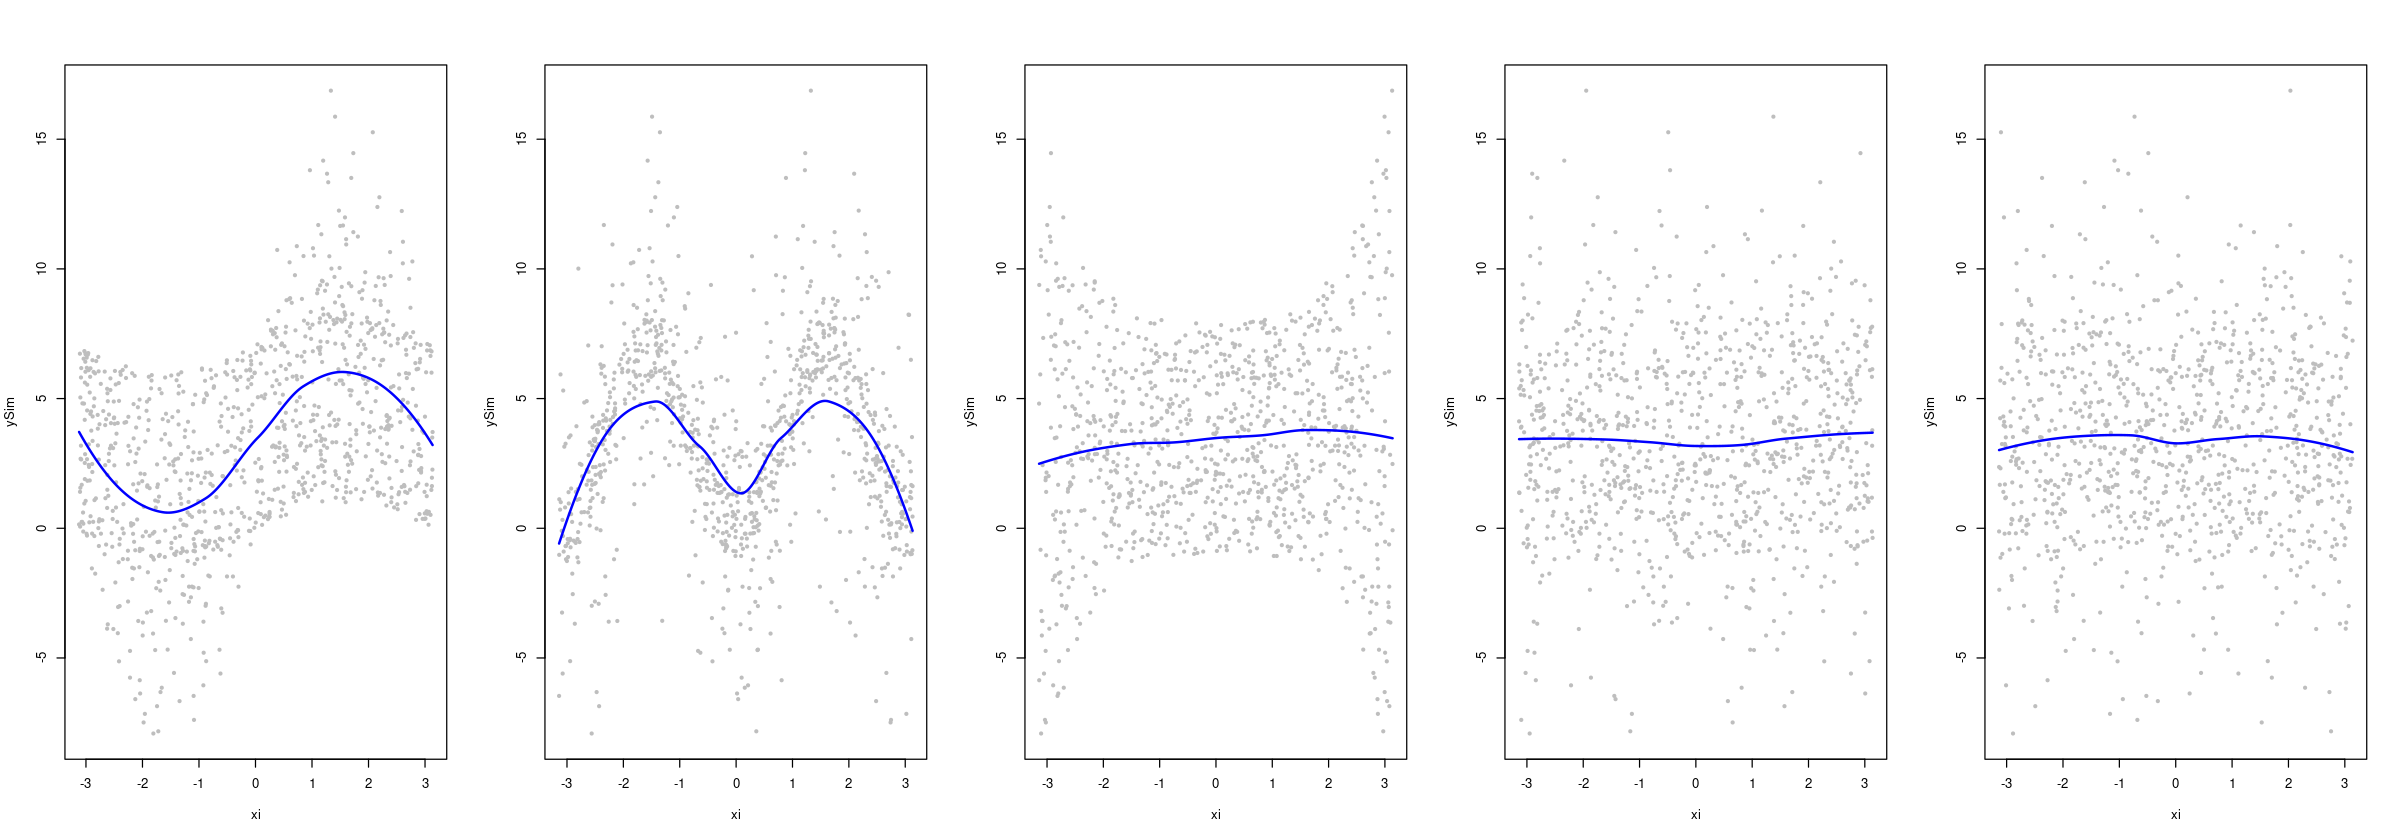

In [16]:
# question 10
N <- 1000

xSim <- matrix(runif(5*N, -pi, pi), N, 5)

ishigamiFun <- function(x){
  sin(x[, 1]) + 7 * sin(x[, 2])^2 + 0.1 * x[, 3]^4 * sin(x[, 1])
}

ySim <- ishigamiFun(xSim)

par(mfrow = c(1, 5))
options(repr.plot.width = 20, repr.plot.height = 7)
for (i in 1:5){
    xi <- xSim[, i]
    plot(xi, ySim, cex = 0.5, pch = 19, col = "grey")
    ss <- loess(y ~ xi, data = data.frame(y = ySim, xi = xi)) # estimation of the conditional expectation
    t <- seq(from = min(xi), to = max(xi), length = 200)
    lines(t, predict(ss, t), col = "blue", lwd = 2)
}


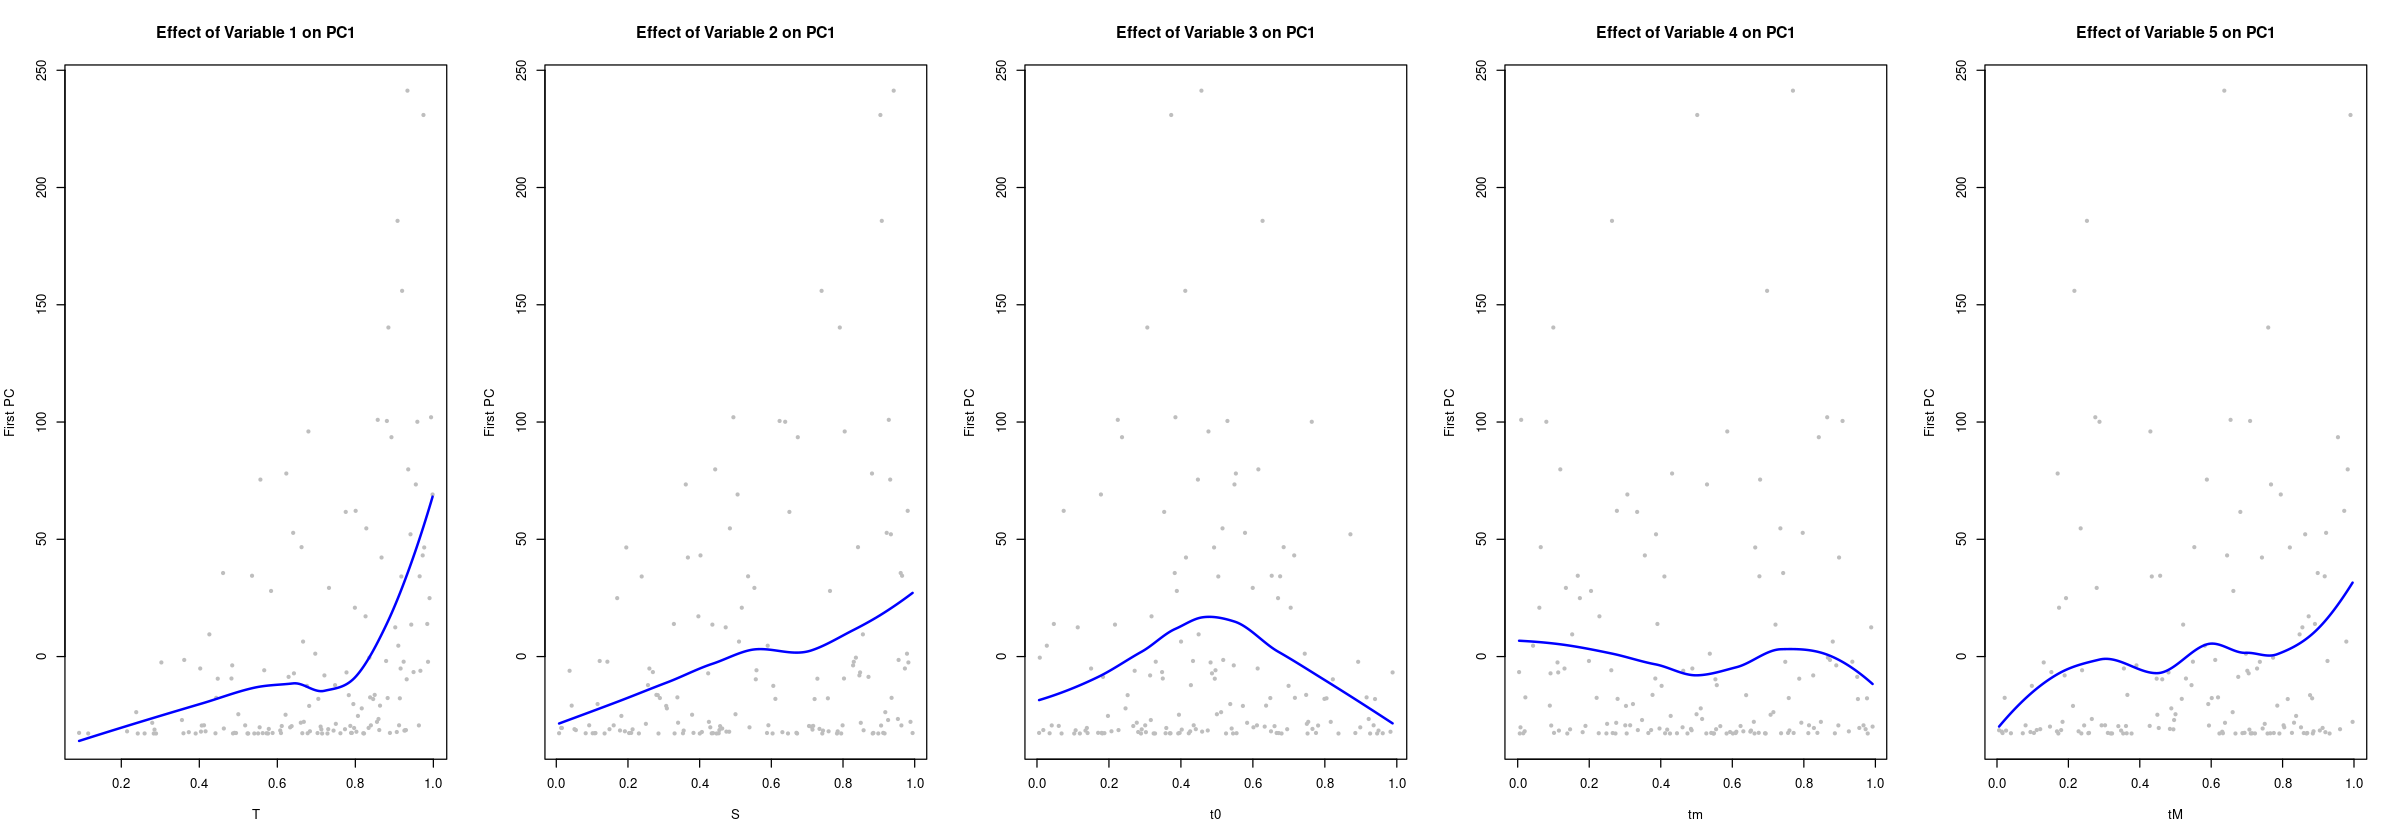

In [17]:
PC1coord <- PCcoord[, 1] 

par(mfrow = c(1, 5)) 
options(repr.plot.width = 20, repr.plot.height = 7)
column_names <- colnames(Xtrain)

for (i in 1:5) {
    xi <- Xtrain[, i] 
    plot(xi, PC1coord, cex = 0.5, pch = 19, col = "grey", 
         xlab = column_names[i], ylab = "First PC", 
         main = paste("Effect of Variable", i, "on PC1"))
    ss <- loess(PC1coord ~ xi, data = data.frame(PC1coord = PC1coord, xi = xi))  
    t <- seq(from = min(xi), to = max(xi), length = 200)
    lines(t, predict(ss, t), col = "blue", lwd = 2)
}


<div class="alert alert-block alert-info"> 
<b>10. Consider again the first PC. We give a code to estimate the conditional mean of the toy function Ishigami. Adapt this code to visualize the main effects of the first PC for all the 5 input variables.
</b>
<br>
<br>
On observe que les trois premières courbes, représentant l'effet des variables T, S, et t0 sur la première composante principale, montrent des variations importantes. Cela indique que ces variables exercent une grande influence sur la première composante principale.
</div>

<div class="alert alert-block alert-info"> 
<b>11. Assumption criticism. In the metamodeling phase, we have modeled *independently* each PC by a GP. Is this assumption justified here? Similarly, in the sensitivity analysis phase, we have assumed all input variables independent and uniform. Is this assumption correct?
</b>
<br>
<br>
Pour PC1, l'hypothèse d'une modélisation indépendante des composantes principales est partiellement justifiée. Les effets principaux des variables comme T, S et t0 dominent, bien que certaines interactions d'ordre 2 existent. Ce n'est cependant pas le cas pour la deuxième composante principale, où les interactions d'ordre 3 sont importantes. Les variables interagissent de manière significative, ce qui remet en cause l'hypothèse d'indépendance des PCs.
<br>
<br>
Dans la phase d'analyse de sensibilité, l'hypothèse d'indépendance des variables est incorrecte, car les interactions jouent un rôle clé. Les interactions d'ordre 2 et 3 sont importantes pour les premières composantes principales, donc les variables ont de fortes interactions. Cela remet en cause l'hypothèse d'indépendance des variables.
<br>
<br>
L'hypothèse uniforme peut également être remise en question, car T semble avoir une influence disproportionnée par rapport aux autres variables.

</div>